# EDA (Exploratory data analysis)

In [1]:
import json
import tqdm
from operator import itemgetter
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import seaborn as sns
import numpy as np
import re
import pandas as pd
from collections import defaultdict
from prettytable import PrettyTable
from wordcloud import WordCloud, STOPWORDS

In [2]:
# folder of data
DATA_FOLDER = '../content'
# path image format
IMAGE_FORMAT = '../content/%s/COCO_%s_%012d.jpg'

In [4]:
"""
    Annotation Format
    
    annotation{
    "question_id" : int,
    "image_id" : int,
    "question_type" : str,
    "answer_type" : str,
    "answers" : [answer],
    "multiple_choice_answer" : str
    }
    
    answer{
    "answer_id" : int,
    "answer" : str,
    "answer_confidence": str
    }
"""
# training annotations
tTrainAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_train2014_annotations.json', 'r'))
# validation annotations
tValAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_val2014_annotations.json', 'r'))

"""
    Input Questions Format
    
    question{
    "question_id" : int,
    "image_id" : int,
    "question" : str
}

"""
# training questions
tTrainQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_train2014_questions.json', 'r'))
# validation questions
tValQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_val2014_questions.json', 'r'))

In [5]:
# Display the 2 first annotations
tTrainAnnotations['annotations'][:2]

[{'question_type': 'what is this',
  'multiple_choice_answer': 'net',
  'answers': [{'answer': 'net', 'answer_confidence': 'maybe', 'answer_id': 1},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 2},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 3},
   {'answer': 'netting', 'answer_confidence': 'yes', 'answer_id': 4},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 5},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 6},
   {'answer': 'mesh', 'answer_confidence': 'maybe', 'answer_id': 7},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 8},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 9},
   {'answer': 'net', 'answer_confidence': 'yes', 'answer_id': 10}],
  'image_id': 458752,
  'answer_type': 'other',
  'question_id': 458752000},
 {'question_type': 'what',
  'multiple_choice_answer': 'pitcher',
  'answers': [{'answer': 'pitcher',
    'answer_confidence': 'yes',
    'answer_id': 1},
   {'answer': 'c

In [6]:
"""
    Function name: GetAllAnswer
    
    Objective: Join a list of answers by ";" to a single string
    
    Summary algorithmic description: Return a list of answers
    
    Input parameters: clAnswers: list of dictionaries of answers
    
    Return : list of answers of a question
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def GetAllAnswer(clAnswers):
    return ';'.join([cdAnswer['answer'] for cdAnswer in clAnswers])

In [7]:
# all answers of second question
GetAllAnswer(tTrainAnnotations['annotations'][1]['answers'])

'pitcher;catcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher'

In [7]:
"""
    Function name: ProcessQuestionAnnotation
    
    Objective: Creates a JSON file whose elements are (img_path, question, ans, answers)
    
    Summary algorithmic description: Loop over all annotations to read all elements
                                     Add every element to the list
                                     Save the list to a JSON file
    
    Input parameters: sDataFolder: "train2014" or "val2014"
    
    Return : None
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessQuestionAnnotation(sDataFolder):
    # Read input annotation data
    tAnnotations = json.load(open(f'{DATA_FOLDER}/v2_mscoco_{sDataFolder}_annotations.json', 'r'))
    # Read input question data
    tQuestions = json.load(open(f'{DATA_FOLDER}/v2_OpenEnded_mscoco_{sDataFolder}_questions.json', 'r'))
    # list of dictionaries whose keys are (img_path, question, ans, answers)
    clData = []

    # Loop over all annotations
    for iC in tqdm.tqdm(range(len(tAnnotations['annotations']))):
        # path image
        sImagePath = IMAGE_FORMAT%(sDataFolder, sDataFolder, tAnnotations['annotations'][iC]['image_id'])
        # question
        sQuestion = tQuestions['questions'][iC]['question']
        # answer
        sAns = tAnnotations['annotations'][iC]['multiple_choice_answer']
        # list of answers
        clAnswers = GetAllAnswer(tAnnotations['annotations'][iC]['answers'])
        # Add a element to the dictionary
        clData.append({'img_path': sImagePath, 'question': sQuestion, 'ans': sAns, 'answers': clAnswers})
    
    # save to disk
    json.dump(clData, open(f'{DATA_FOLDER}/vqa_raw_{sDataFolder}.json', 'w'))

In [8]:
# # Creates a JSON file whose elements are (img_path, question, ans, answers) for train data
# ProcessQuestionAnnotation("train2014")
# # Creates a JSON file whose elements are (img_path, question, ans, answers) for val data
# ProcessQuestionAnnotation("val2014")

In [8]:
# Read trainning data
tTrainData = json.load(open(f'{DATA_FOLDER}/vqa_raw_train2014.json', 'r'))
# Read validation data
tValData = json.load(open(f'{DATA_FOLDER}/vqa_raw_val2014.json', 'r'))

In [9]:
# Display the 5 first lines
tTrainData[:5]

[{'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What is this photo taken looking through?',
  'ans': 'net',
  'answers': 'net;net;net;netting;net;net;mesh;net;net;net'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What position is this man playing?',
  'ans': 'pitcher',
  'answers': 'pitcher;catcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher;pitcher'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'What color is the players shirt?',
  'ans': 'orange',
  'answers': 'orange;orange;orange;orange;orange;orange;orange;orange;orange;orange'},
 {'img_path': '../content/train2014/COCO_train2014_000000458752.jpg',
  'question': 'Is this man a professional baseball player?',
  'ans': 'yes',
  'answers': 'yes;yes;yes;yes;yes;no;yes;yes;yes;yes'},
 {'img_path': '../content/train2014/COCO_train2014_000000262146.jpg',
  'question': 'What color is the snow?',
  'ans': 'whit

In [10]:
# list of questions
clQuestion = list(map(itemgetter('question'), tTrainData))
# list of answers
clAns = list(map(itemgetter('ans'), tTrainData))
# list of image paths
clImagePath = list(map(itemgetter('img_path'), tTrainData))

In [11]:
"""
    Function name: DisplayImage
    
    Objective: Display Visual Question Answering
    
    Summary algorithmic description: Read an image from a file into an array
                                     Display image with a title of question and answer
    
    Input parameters: iIndex : index of image
    
    Return : None
    
    Date : 26/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def DisplayImage(iIndex):
    # Read an image from a file into an array
    caImage = plt.imread(clImagePath[iIndex])
    # Create a new figure,
    plt.figure()
    # Set a title for the figure : question and it's answer
    plt.title(f'Q: {clQuestion[iIndex]} \n A: {clAns[iIndex]}')
    # Display image
    plt.imshow(caImage)

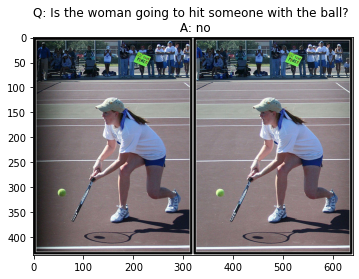

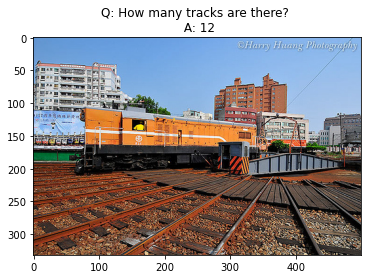

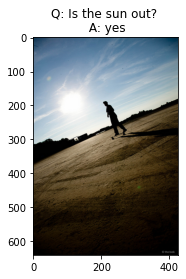

In [12]:
# Display Visual Question Answering for 3 random images
for iC in random.sample(range(0, len(clImagePath)), 3):
    DisplayImage(iC)

In [15]:
# image shapes
clImageShape = []
# Loop over all images
for sImage in clImagePath:
    # Load an image from a file
    caImage = cv2.imread(sImage)
    # Add shape of the image to the list
    clImageShape.append(caImage.shape)

In [17]:
# list of heights of images
clHeight = list(map(itemgetter(0), clImageShape)) 
# list of widths of images
clWidth = list(map(itemgetter(1), clImageShape)) 
# list of channels of images
clChannel = list(map(itemgetter(2), clImageShape))

C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


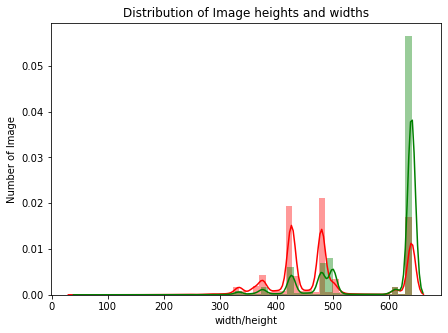

In [18]:
# Create a new figure with a size (7,5)
plt.figure(figsize=(7,5))
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(clHeight, color='red')
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(clWidth, color='green')
# Set a title for the figure
plt.title('Distribution of Image heights and widths')
# Set the label for the x-axis
plt.xlabel('width/height')
# Set the label for the y-axis
plt.ylabel('Number of Image')
# Display the figure
plt.show()

In [19]:
print("MAX Height: {}, MIN Height: {}, MEAN Height: {}".format(max(clHeight), min(clHeight), np.round(np.mean(clHeight),2)))
print("MAX Width: {}, MIN Width: {}, MEAN Width: {}".format(max(clWidth), min(clWidth), np.round(np.mean(clWidth),2)))

MAX Height: 640, MIN Height: 51, MEAN Height: 482.51
MAX Width: 640, MIN Width: 59, MEAN Width: 580.63


In [14]:
# Question sample of 20
clIdxQuestionSample = random.sample(range(0, len(clQuestion)), 20)
# Loop over all sample questions
for iIndex in clIdxQuestionSample:
    # Print question
    print(clQuestion[iIndex])
    print('_'*50)

What color is the shower curtain?
__________________________________________________
What's in the coke?
__________________________________________________
What event are the people celebrating?
__________________________________________________
Is the man in the dark blue shirt trying to hurt the man in the light blue shirt?
__________________________________________________
Is the white object a frisbee?
__________________________________________________
Where was the picture taken of the a clock?
__________________________________________________
Is the boat moving?
__________________________________________________
How many boats?
__________________________________________________
During what season does this scene take place?
__________________________________________________
What color is the hairbrush?
__________________________________________________
How many total ears are there in this picture?
__________________________________________________
Are the elephants going for a 

In [21]:
# list of lengths of questions
clQuestionLength = []
# list of words
clWord = []
# Loop over all questions
for sQuestion in tqdm.tqdm(clQuestion):
    # Add a question length to the list
    clQuestionLength.append(len(sQuestion.split(" ")))
    # Loop over all words in a question
    for sWord in sQuestion.split(" "):
        # Add a word to the list
        clWord.append(sWord)

# Set of words
csWord = set(clWord)

100%|██████████| 443757/443757 [00:01<00:00, 417407.31it/s]


C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


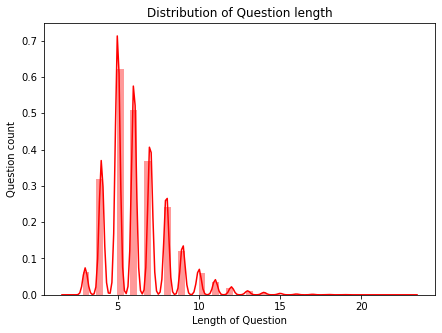

In [23]:
# Create a new figure with a size (7,5)
plt.figure(figsize=(7,5))
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(clQuestionLength, color='red')
# Set a title for the figure
plt.title('Distribution of Question length')
# Set the label for the x-axis
plt.xlabel('Length of Question')
# Set the label for the y-axis
plt.ylabel('Question count')
# Display the figure
plt.show()

In [24]:
print('BEFORE DATA CLEANING')
print('-'*35)
print("A sentence has max words:", max(clQuestionLength))
print("A sentence has min words:",min(clQuestionLength))
print('A sentence has average words:',int(sum(clQuestionLength)/len(clQuestionLength)))
print('There are total', len(csWord),'unique words')

BEFORE DATA CLEANING
-----------------------------------
A sentence has max words: 23
A sentence has min words: 2
A sentence has average words: 6
There are total 22226 unique words


In [25]:
# a set of letters
ALPHABET = 'qwertyuiopasdfghjklzxcvbnmQWERTYUIOPASDFGHJKLZXCVBNM0123456789'

In [26]:
# list of letters that're not in alphabet
clLetterNotAlphatbet = []
# Loop over all words
for sWord in csWord:
    # Loop over all letters in alphabet
    for sLetter in ALPHABET:
        # Remove alphabet letter in the word
        sWord = sWord.replace(sLetter,'')
    # Add this word as not alphabet     
    clLetterNotAlphatbet.append(sWord)

In [27]:
# non-alphabet string
sLettersNotAlphatbet = ''
# Loop over all words as not alphabet  
for sLetters in clLetterNotAlphatbet:
    # Add this to the string
    sLettersNotAlphatbet += sLetters
# Set of non-alphabet letters
csLetterNotAlphabet = set(sLettersNotAlphatbet)

In [34]:
len(csLetterNotAlphabet)

21

In [28]:
# concatanate all the special symbols to a single string 'SYMBOLS_TO_REMOVE'
SYMBOLS_TO_REMOVE = ''.join(sLetter for sLetter in csLetterNotAlphabet)
print('There are total',len(SYMBOLS_TO_REMOVE),'non-alphabet characters (including digits) in our corpus.')

There are total 21 non-alphabet characters (including digits) in our corpus.


In [29]:
# letters to remove
SYMBOLS_TO_REMOVE

'+#^?:;,-$"_().`/\'*&%!'

## Data Cleaning

In [30]:
# contraction mappings
CONTRACTIONS = {"aint": "ain't", "arent": "aren't", "cant": "can't", 
                "couldve": "could've", "couldnt": "couldn't", "couldn'tve": "couldn't've", "couldnt've": "couldn't've", 
                "didnt": "didn't", "doesnt": "doesn't", "dont": "don't", 
                "hadnt": "hadn't", "hadnt've": "hadn't've", "hadn'tve": "hadn't've", "hasnt": "hasn't", "havent": "haven't", 
                "hed": "he'd", "hed've": "he'd've", "he'dve": "he'd've", "hes": "he's", 
                "howd": "how'd", "howll": "how'll", "hows": "how's", 
                "Id've": "I'd've", "I'dve": "I'd've", "Im": "I'm", "Ive": "I've", 
                "isnt": "isn't", "itd": "it'd", "itd've": "it'd've", "it'dve": "it'd've", "itll": "it'll", 
                "let's": "let's", 
                "maam": "ma'am", 
                "mightnt": "mightn't", "mightnt've": "mightn't've", "mightn'tve": "mightn't've", "mightve": "might've", 
                "mustnt": "mustn't", "mustve": "must've", 
                "neednt": "needn't", "notve": "not've", 
                "oclock": "o'clock", 
                "oughtnt": "oughtn't", 
                "ow's'at": "'ow's'at", "'ows'at": "'ow's'at", "'ow'sat": "'ow's'at", 
                "shant": "shan't", "shed've": "she'd've", "she'dve": "she'd've", "she's": "she's", 
                "shouldve": "should've", "shouldnt": "shouldn't", "shouldnt've": "shouldn't've", "shouldn'tve": "shouldn't've", 
                "somebody'd": "somebodyd", "somebodyd've": "somebody'd've", "somebody'dve": "somebody'd've", 
                "somebodyll": "somebody'll", "somebodys": "somebody's", "someoned": "someone'd", "someoned've": "someone'd've", 
                "someone'dve": "someone'd've", "someonell": "someone'll", "someones": "someone's", "somethingd": "something'd", 
                "somethingd've": "something'd've", "something'dve": "something'd've", "somethingll": "something'll", 
                "thats": "that's", 
                "thered": "there'd", "thered've": "there'd've", "there'dve": "there'd've", "therere": "there're", 
                "theres": "there's", 
                "theyd": "they'd", "theyd've": "they'd've", "they'dve": "they'd've", "theyll": "they'll", 
                "theyre": "they're", "theyve": "they've", 
                "twas": "'twas", "wasnt": "wasn't", 
                "wed've": "we'd've", "we'dve": "we'd've", 
                "weve": "we've", "werent": "weren't", 
                "whatll": "what'll", "whatre": "what're", "whats": "what's", "whatve": "what've", 
                "whens": "when's", 
                "whered": "where'd", "where's": "where is", "whereve": "where've", 
                "whod": "who'd", "whod've": "who'd've", "who'dve": "who'd've", "wholl": "who'll", "whos": "who's", 
                "whove": "who've", 
                "whyll": "why'll", "whyre": "why're", "whys": "why's", 
                "wont": "won't", 
                "wouldve": "would've", "wouldnt": "wouldn't", "wouldnt've": "wouldn't've", "wouldn'tve": "wouldn't've", 
                "yall": "y'all", "yall'll": "y'all'll", "y'allll": "y'all'll", "yall'd've": "y'all'd've", 
                "y'alld've": "y'all'd've", "y'all'dve": "y'all'd've", 
                "youd": "you'd", "youd've": "you'd've", "you'dve": "you'd've", 
                "youll": "you'll", "youre": "you're", "youve": "you've"}

In [31]:
# list of punctuations to remove
PUNCTUATIONS = [';', r"/", '[', ']', '"', '{', '}',
                '(', ')', '=', '+', '\\', '_', '-',
                '*', ':', '^', '%', '$', '#', '&',
                '>', '<', '@', '`', ',', '?', '!']

In [39]:
"""
    Function name: ProcessSentence
    
    Objective: Clean a given raw sentence
    
    Summary algorithmic description: Remove redundant white spaces, punctuations
    
    Input parameters: sSentence: sentence to process
    
    Return : the cleaned version of the sentence
    
    Date : 09/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ProcessSentence(sSentence):
    # Remove the character ".", except from floating numbers
    oPeriodStrip  = re.compile("(?!<=\d)(\.)(?!\d)")
    # Remove any "," between digits, eg: 5,6
    oCommaStrip   = re.compile("(\d)(\,)(\d)")

    # Replace new line with a white space
    sInText = sSentence.replace('\n', ' ')
    # Replace multiple white space with single white space
    sInText = sInText.replace('\t', ' ')
    # Remove leading and trailing whitespaces
    sInText = sInText.strip()
    # The result of process
    sOutText = sInText
    # Loop over all punctuations
    for p in PUNCTUATIONS:
        # If p + ' ' ou ' ' + p ou ',' between digits in the sentence
        if (p + ' ' in sInText or ' ' + p in sInText) or (re.search(oCommaStrip, sInText) != None):
            # All occurrences of p replaced by ''
            sOutText = sOutText.replace(p, '')
        # If not
        else:
            # Replace p by a white space 
            sOutText = sOutText.replace(p, ' ')
    # Replace the character "." by the ''.
    sOutText = oPeriodStrip.sub("", sOutText)
    # Convert the sentence to lowercase, then to a list of words
    sOutText = sOutText.lower().split()
    # Loop over the words
    for iWordId, sWord in enumerate(sOutText):
        # If the word is a contraction
        if sWord in CONTRACTIONS:
            # Convert it to the right format of the contraction
            sOutText[iWordId] = CONTRACTIONS[sWord]
    # Concatenate of all the words to a sentence
    sOutText = ' '.join(sOutText)
    # Return the cleaned version of the sentence
    return sOutText

In [46]:
clQuestionExample = ["Is the snow in this picture probably natural , or probably man-made ?", 
         "What color is the woman's shirt?",
         "Where's the man ... looking at?"]

for sQuestion in clQuestionExample:
    print('BEFORE: ', sQuestion)
    sProcessedQuestion = ProcessSentence(sQuestion)
    print('AFTER : ', sProcessedQuestion)
    print('-'*50)

BEFORE:  Is the snow in this picture probably natural , or probably man-made ?
AFTER :  is the snow in this picture probably natural or probably man made
--------------------------------------------------
BEFORE:  What color is the woman's shirt?
AFTER :  what color is the woman's shirt
--------------------------------------------------
BEFORE:  Where's the man ... looking at?
AFTER :  where is the man looking at
--------------------------------------------------


In [47]:
# Clean all raw sentences
dfQuestionProcessed = pd.Series(clQuestion).apply(ProcessSentence)

In [49]:
clFirstWord = []
for sQuestion in tqdm.tqdm(dfQuestionProcessed):
    clFirstWord.append(sQuestion.split()[0].lower())

100%|██████████| 443757/443757 [00:00<00:00, 926919.13it/s]


In [50]:
print('There are ',len(set(clFirstWord)),' type of questions in the dataset.')

There are  271  type of questions in the dataset.


In [51]:
# question frequencies
cdQuestionFreq = defaultdict(int)
# Loop over all types of questions
for sKey in list(clFirstWord):
    # Question frequency inscrease
    cdQuestionFreq[sKey] += 1

# top 10 most frequents questions 
cdSortedFreq = sorted(cdQuestionFreq.items(), key=itemgetter(1), reverse=True)[0: 10]
# Result of top 10 most frequents questions 
ctTopQuestion, ctTopFreq = zip(*cdSortedFreq)

In [52]:
# question frequency table
oQuestionFrequencyTable = PrettyTable(["Question Type", "Question Count", "Coverage"])

for i in range(10):
    # Row of table
    clRow = []
    # Question Type
    clRow.append(ctTopQuestion[i])
    # Question Count
    clRow.append(ctTopFreq[i])
    # Coverage of this question
    clRow.append(np.round((ctTopFreq[i] / sum(ctTopFreq)) * 100, 2))
    # 
    oQuestionFrequencyTable.add_row(clRow)

# Display the table 
print(oQuestionFrequencyTable)

+---------------+----------------+----------+
| Question Type | Question Count | Coverage |
+---------------+----------------+----------+
|      what     |     182842     |   42.9   |
|       is      |     113774     |   26.7   |
|      how      |     53426      |  12.54   |
|      are      |     33136      |   7.78   |
|     where     |     12409      |   2.91   |
|      does     |     12021      |   2.82   |
|     which     |      5382      |   1.26   |
|       do      |      4983      |   1.17   |
|      why      |      4891      |   1.15   |
|      who      |      3322      |   0.78   |
+---------------+----------------+----------+


In [62]:
"""
    Function name: ShowWordCloud
    
    Objective: Generate wordcloud from data
    
    Summary algorithmic description: Generate and display the wordcloud from data
    
    Input parameters: clData: data to generate wordcloud
                      sTitle : title of wordcloud
    
    Return : None
    
    Date : 28/11/2021
    
    Coding: INSA CVL - Van Tuan BUI  
"""
def ShowWordCloud(clData, sTitle = None):
    # Generate wordcloud from data
    oWordcloud = WordCloud(
        background_color='white',
        max_font_size=40, 
        scale=5,
        random_state=1
    ).generate(" ".join(clData))

    # Create a new figure with a size (15,12)
    oFigure = plt.figure(1, figsize=(15,12))
    # Turn off axis lines and labels
    plt.axis('off')
    # If titre is different to None
    if sTitle: 
        # Add a centered suptitle to the figure
        oFigure.suptitle(sTitle, fontsize=20)
        # Adjust the position of the top edge of subplot layout 
        oFigure.subplots_adjust(top=2.3)
        
    # Display wordcloud image
    plt.imshow(oWordcloud)
    # # Display the figure
    plt.show()

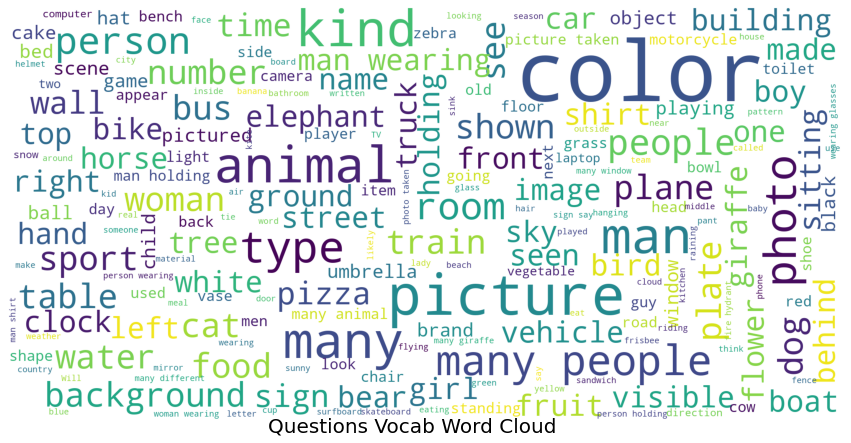

In [63]:
# Generate wordcloud from words of questions 
ShowWordCloud(clWord, sTitle = 'Questions Vocab Word Cloud')

# Answers

In [78]:
# answer frequencies
cdAnswerFreq= defaultdict(int)
# Loop over all answers
for sAnswer in list(map(itemgetter('ans'), tTrainData)):
    # Answer frequency inscrease
    cdAnswerFreq[sAnswer] += 1

# top 10 most frequents answers 
cdSortedFreq = sorted(cdAnswerFreq.items(), key=itemgetter(1), reverse=True)[0: 1000]
# # Result of top 10 most frequents answers
ctTopAnswer, ctTopFreq = zip(*cdSortedFreq)

In [66]:
print('There are total ', len(cdAnswerFreq), ' different types of answers.')

There are total  22531  different types of answers.


C:\Users\vbui\anaconda3\envs\VQA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


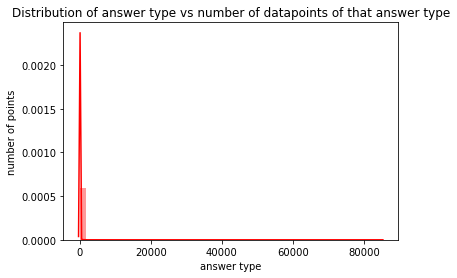

In [67]:
# Show a default plot with a kernel density estimate and histogram with bin size determined automatically
sns.distplot(list(cdAnswerFreq.values()), color='red')
# Set a title for the figure
plt.title('Distribution of answer type vs number of datapoints of that answer type')
# Set the label for the x-axis
plt.xlabel('answer type')
# Set the label for the y-axis
plt.ylabel('number of points')
# Display the figure
plt.show()

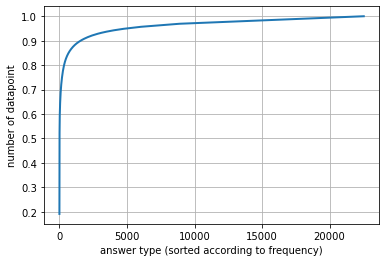

In [71]:
# descending sort of answer frequencies 
caAnswerCount = sorted(list(cdAnswerFreq.values()), reverse=True) / np.sum(list(cdAnswerFreq.values()));
# the cumulative sum of the answer frequencies 
caAnswerCountCum = np.cumsum(caAnswerCount)
#  Create a new figure with a size (6,4)
plt.figure(1, figsize=(6, 4))
# Clear the current figure
plt.clf()
# Plot y (the cumulative sum of the answer frequencies) versus x (answer type) as lines
plt.plot(caAnswerCountCum, linewidth=2)
# Set limits just large enough
plt.axis('tight')
# grid lines
plt.grid()
# Set the label for the x-axis
plt.xlabel('answer type (sorted according to frequency)')
# Set the label for the y-axis
plt.ylabel('number of datapoint')
# Display the figure
plt.show()

In [77]:
# answer frequency threshold
ANSWER_FREQUENCY_THRESHOLD = 0.875
# first index of most answers frequencies that covers about 87.5% of our train data 
iIdx = [iIdx for iIdx, fFreq in enumerate(caAnswerCountCum) if fFreq > ANSWER_FREQUENCY_THRESHOLD][0]
print(f'Top {iIdx + 1} answer-type covers about {ANSWER_FREQUENCY_THRESHOLD * 100}% of our train data')

Top 1005 answer-type covers about 87.5% of our train data


In [79]:
# answer frequency table
oAnswerFrequencyTable = PrettyTable(["Answer Type", "Answer Count", "Coverage(%)"])

for iC in range(10):
    # Row of table
    clRow = []
    # Answer Type
    clRow.append(ctTopAnswer[iC])
    # Answer Count
    clRow.append(ctTopFreq[iC])
    # Coverage of this answer
    clRow.append(np.round((ctTopFreq[iC]/sum(ctTopFreq))*100, 2))
    # Add this row
    oAnswerFrequencyTable.add_row(clRow)

# Print answer frequency table
print(oAnswerFrequencyTable)

+-------------+--------------+-------------+
| Answer Type | Answer Count | Coverage(%) |
+-------------+--------------+-------------+
|     yes     |    84978     |    21.89    |
|      no     |    82516     |    21.26    |
|      1      |    12540     |     3.23    |
|      2      |    12215     |     3.15    |
|    white    |     8916     |     2.3     |
|      3      |     6536     |     1.68    |
|     blue    |     5455     |     1.41    |
|     red     |     5201     |     1.34    |
|    black    |     5066     |     1.31    |
|      0      |     4977     |     1.28    |
+-------------+--------------+-------------+
